In [372]:
import pandas as pd
import random
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import xgboost as xgb

from scipy.stats import skew
from scipy.special import expit as sigmoid
from scipy.cluster.hierarchy import fclusterdata
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
train_set = pd.read_csv("data/train.csv")
test_set = pd.read_csv("data/test.csv")

In [4]:
test_set['SalePrice'] = -1.0
global_set = pd.concat([train_set, test_set])

# Task 1:
Select a set of 10-15 of the most interesting variables.  Do a pairwise Pearson correlation analysis on all pairs of these variables. Show the result with heat map and find out most positive and negative correlations. 

In [5]:
# suspects = ["SalePrice", "RH", "RL", "RP", "RM", "LotFrontage", "LotArea"]
suspects = ["SalePrice", "LotFrontage", "LotArea", "PoolArea", "YrSold", "OverallQual", "TotalBsmtSF", "1stFlrSF", "GrLivArea", "GarageCars",
            "GarageArea", "YearBuilt", "BedroomAbvGr", "KitchenAbvGr", "MasVnrArea", "YearRemodAdd"]
train_set[suspects].head()

,SalePrice,LotFrontage,LotArea,PoolArea,YrSold,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageCars,GarageArea,YearBuilt,BedroomAbvGr,KitchenAbvGr,MasVnrArea,YearRemodAdd
0,208500,65.0,8450,0,2008,7,856,856,1710,2,548,2003,3,1,196.0,2003
1,181500,80.0,9600,0,2007,6,1262,1262,1262,2,460,1976,3,1,0.0,1976
2,223500,68.0,11250,0,2008,7,920,920,1786,2,608,2001,3,1,162.0,2002
3,140000,60.0,9550,0,2006,7,756,961,1717,3,642,1915,3,1,0.0,1970
4,250000,84.0,14260,0,2008,8,1145,1145,2198,3,836,2000,4,1,350.0,2000


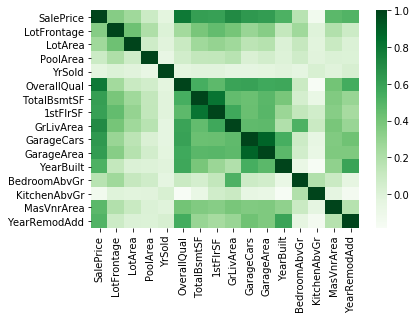

In [6]:
sns.heatmap(train_set[suspects].corr(), cmap="Greens")

In [7]:
train_set[suspects].corr()

,SalePrice,LotFrontage,LotArea,PoolArea,YrSold,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageCars,GarageArea,YearBuilt,BedroomAbvGr,KitchenAbvGr,MasVnrArea,YearRemodAdd
SalePrice,1.000000,0.351799,0.263843,0.092404,-0.028923,0.790982,0.613581,0.605852,0.708624,0.640409,0.623431,0.522897,0.168213,-0.135907,0.477493,0.507101
LotFrontage,0.351799,1.000000,0.426095,0.206167,0.007450,0.251646,0.392075,0.457181,0.402797,0.285691,0.344997,0.123349,0.263170,-0.006069,0.193458,0.088866
LotArea,0.263843,0.426095,1.000000,0.077672,-0.014261,0.105806,0.260833,0.299475,0.263116,0.154871,0.180403,0.014228,0.119690,-0.017784,0.104160,0.013788
PoolArea,0.092404,0.206167,0.077672,1.000000,-0.059689,0.065166,0.126053,0.131525,0.170205,0.020934,0.061047,0.004950,0.070703,-0.014525,0.011723,0.005829
YrSold,-0.028923,0.007450,-0.014261,-0.059689,1.000000,-0.027347,-0.014969,-0.013604,-0.036526,-0.039117,-0.027378,-0.013618,-0.036014,0.031687,-0.008201,0.035743
OverallQual,0.790982,0.251646,0.105806,0.065166,-0.027347,1.000000,0.537808,0.476224,0.593007,0.600671,0.562022,0.572323,0.101676,-0.183882,0.411876,0.550684
TotalBsmtSF,0.613581,0.392075,0.260833,0.126053,-0.014969,0.537808,1.000000,0.819530,0.454868,0.434585,0.486665,0.391452,0.050450,-0.068901,0.363936,0.291066
1stFlrSF,0.605852,0.457181,0.299475,0.131525,-0.013604,0.476224,0.819530,1.000000,0.566024,0.439317,0.489782,0.281986,0.127401,0.068101,0.344501,0.240379
GrLivArea,0.708624,0.402797,0.263116,0.170205,-0.036526,0.593007,0.454868,0.566024,1.000000,0.467247,0.468997,0.199010,0.521270,0.100063,0.390857,0.287389
GarageCars,0.640409,0.285691,0.154871,0.020934,-0.039117,0.600671,0.434585,0.439317,0.467247,1.000000,0.882475,0.537850,0.086106,-0.050634,0.364204,0.420622


## Conclusion (11 features):
1.  Correlated features with SalePrice from highest to lowest order SalesPrivce vs All... </br>
    a. Overall quality of material (OverallQual, 0.79) </br>
    b. Above grade living area in square feet (GrLivArea, 0.70) </br>
    c. Size of garage in car capacity (GarageCars, 0.64) </br>
    d. Size of garage in square feet (GarageArea, 0.62) </br>
    e. Total basement area in square feet (TotalBsmtSF, 0.61)</br>
    f. First Floor area in square feet (1stFlrSF, 0.60) </br>
2. Overall quality of the house is highly correlated to the year it was built, the newer the house higher its quality (0.57)
3. Overall quality of the house is highly correlated to the year it was remodeled, most recent modeled house has higher quality (0.55)
4. Overall quality of the house is highly correlated to the garage cars capacity, the more cars a house can manage higher its quality (0.60)
5. Lot frontage (linear feet of street connected to house) is correlated with Lot Area (lot area in sq. feet around the house) (0.42)

# Task 2
Produce five other informative plots revealing aspects of this data. For each plot, write a paragraph in your notebook describing what interesting properties your visualization reveals. These must include: </br>
1. at least one line chart </br>
2. at least one scatter plot or data map </br>
3. at least one histogram or bar chart </br>


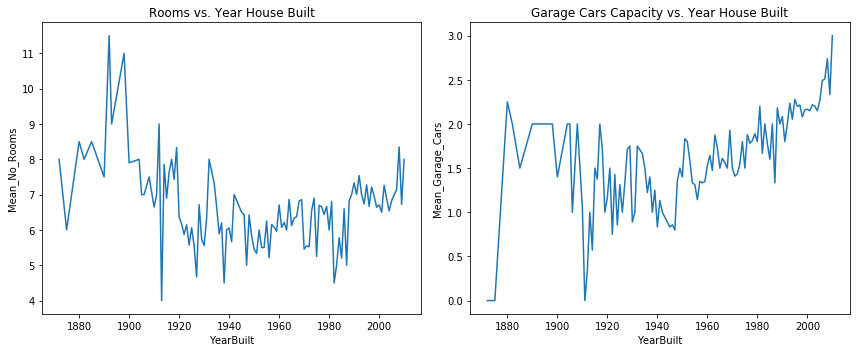

In [8]:
figures, axes = plt.subplots(1, 2, figsize=(12,5))

# TotRmsAbvGrd
totalRoomsYearAgg = train_set.groupby(["YearBuilt"])["TotRmsAbvGrd"].agg(["mean"]).reset_index()
totalRoomsYearAgg = totalRoomsYearAgg.rename(columns={"mean": "Mean_No_Rooms"})
sns.lineplot(x="YearBuilt", y="Mean_No_Rooms", data=totalRoomsYearAgg, markers=True, ax=axes[0])
axes[0].set_title("Rooms vs. Year House Built")
# GarageCars

garageCarsYearAgg = train_set.groupby(["YearBuilt"])["GarageCars"].agg(["mean"]).reset_index()
garageCarsYearAgg = garageCarsYearAgg.rename(columns={"mean": "Mean_Garage_Cars"})
sns.lineplot(x="YearBuilt", y="Mean_Garage_Cars", data=garageCarsYearAgg, markers=True, ax=axes[1])
axes[1].set_title("Garage Cars Capacity vs. Year House Built")

plt.tight_layout()

### Conclusion (Task 2):
Changes in Mean number of rooms as the houses are built through a period of time
1. Steady increase from 6 room to 11 rooms from 1880 to 1900
2. Significant drop in mean no. of rooms from 1900s till 1940s (possible due to world war atmosphere people were hesitating to build full-fledge houses to avoid rebuilding)
3. A gradual increase in mean no. of rooms from 1950s to late 2000s (possible due to rise in nuclear family trends as time proceeded, due to reduction in few people per house)

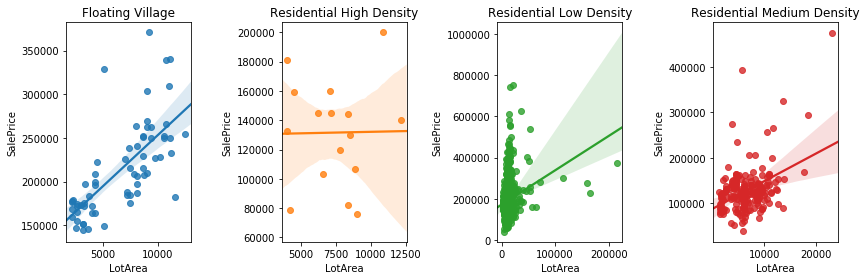

In [9]:
figures, axes = plt.subplots(1, 4, figsize=(12,4))
residency_types = ['FV', 'RH','RL','RM']
labels = ["Floating Village", "Residential High Density", "Residential Low Density", "Residential Medium Density"]
for index, residency_type in enumerate(residency_types):
    residency = train_set[train_set.MSZoning == residency_type]
    sns.regplot(x='LotArea', y='SalePrice', data=residency, ax=axes[index])
    axes[index].set_title(labels[index])

plt.tight_layout()

### Conclusion (Task 2):
1. In Floating Village, Low Density, Medium Density Residential zones a strong correlation in SalePrice at Lot-Area is observed
2. In Highly Dense Residential, there's no correlation between SalePrice vs LotArea (may be there are other factors that influence SalePrice in High Residential Zones other than Lot-Area)

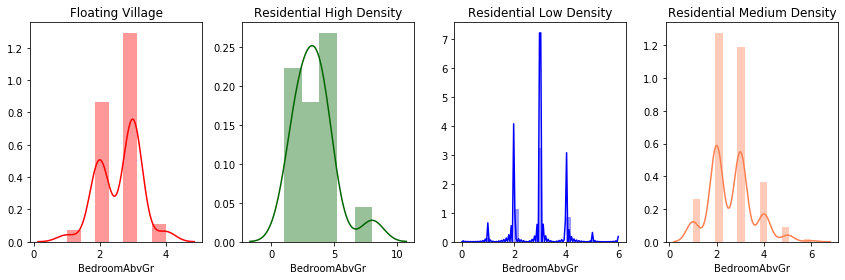

In [10]:
figures, axes = plt.subplots(1, 4, figsize=(12,4))
residency_types = ['FV', 'RH', 'RL', 'RM']
labels = ["Floating Village", "Residential High Density", "Residential Low Density", "Residential Medium Density"]
colors = ['red', 'darkgreen', 'blue', 'coral']
for index, residency_type in enumerate(residency_types):
    residency_data = train_set[train_set.MSZoning == residency_type]
    sns.distplot(residency_data.BedroomAbvGr, ax=axes[index], color=colors[index])
    axes[index].set_title(labels[index])
plt.tight_layout()

### Conclusion (Task 2):
1. Average number of bedrooms range in 1 to 5 in Residential High Density
2. Maximum residents in Residential Low Density live within houses of 3 bedrooms


C:\Users\Paras\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Paras\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


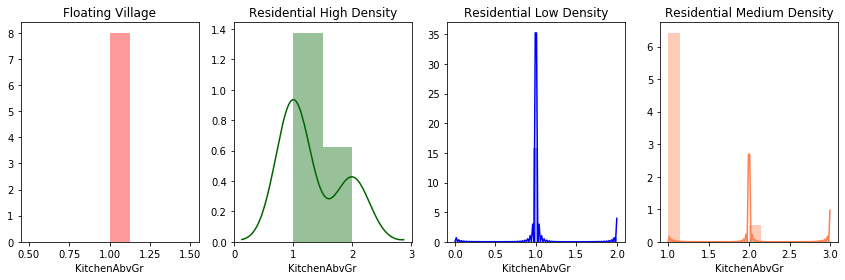

In [11]:
figures, axes = plt.subplots(1, 4, figsize=(12,4))
residency_types = ['FV', 'RH', 'RL', 'RM']
labels = ["Floating Village", "Residential High Density", "Residential Low Density", "Residential Medium Density"]
colors = ['red', 'darkgreen', 'blue', 'coral']
for index, residency_type in enumerate(residency_types):
    residency_data = train_set[train_set.MSZoning == residency_type]
    sns.distplot(residency_data['KitchenAbvGr'], ax=axes[index], color=colors[index])
    axes[index].set_title(labels[index])
plt.tight_layout()

## Task 3

In [12]:
# train_set[["OverallQual","GrLivArea","GarageCars","GarageArea","TotalBsmtSF","1stFlrSF"]].isnull().sum()

In [13]:
# global_set[["OverallQual","GrLivArea","GarageCars","GarageArea","TotalBsmtSF","1stFlrSF", "YearBuilt", "YearRemodAdd", "PoolArea"]].describe()

In [14]:
def max_min_scaler(min_val, max_val, val):
    return (val - min_val)/(max_val - min_val)

## Desirability Score:
1. Took significantly correlated features and applied min-max scaling on them to compute their score
2. Took other features which dictated high Sale Prices in their pivot group: type of house/type of street/type of exterior condition/year built/pool area
3. Applied on min-max scaling to compute score on each feature
4. Normalised all scores and computed a rating on a scale from 1 to 10 to express desirability
5. The basic intuition behind desirability scores, is that the most desirable houses would be expensive because of the high economical demand

In [15]:
max_int = sys.maxsize - 1 # Maximum possible integer value in python
min_int = (-max_int - 1) + 2 # Minimum possible integer value in python
def desirability_score(row):
    score = 0.0
    correlated_cols_weights = {"OverallQual": 0.79, "GrLivArea": 0.70, "GarageCars": 0.64 , "GarageArea": 0.62, "TotalBsmtSF": 0.61, "1stFlrSF": 0.60}
    correlated_cols_mins = {"OverallQual": 1.0, "GrLivArea": 334.0, "GarageCars": 0.0, "GarageArea": 0.0, "TotalBsmtSF": 0.0, "1stFlrSF": 334.0}
    correlated_cols_max = {"OverallQual": 10.0, "GrLivArea": 5642.0, "GarageCars": 5.0, "GarageArea": 1488.0, "TotalBsmtSF": 6110.0, "1stFlrSF": 5095.0}
    for c in correlated_cols_weights:
        score += max_min_scaler(correlated_cols_mins[c], correlated_cols_max[c], row[c])
    
#     print(str(score))
    
    # Higher weight if a 2 Story or newer dwelling then assign higher score
    if row["MSSubClass"] in [20, 60, 0, 75, 160]:
        score += 1.0
    else:
        score += 0.0
    
    # Higher weight if the street closed to house is Paved or made from Gravel
    if row["Street"] == "Pave":
        score += 1.0
    else:
        score += 0.0
        
    # Higher weight if the exterior material quality is Excellent
    if row["ExterCond"] == "Ex":
        score += 1.0
    else:
        score += 0.0
                
    neighborhood = ['MeadowV', 'IDOTRR', 'BrDale', 'BrkSide', 'Edwards', 'OldTown', 'Sawyer', 'Blueste', 'SWISU', 'NPkVill', 'NAmes', 'Mitchel', 'SawyerW', 'NWAmes', 'Gilbert', 'Blmngtn', 'CollgCr', 'Crawfor', 'ClearCr', 'Somerst', 'Veenker', 'Timber', 'StoneBr', 'NridgHt', 'NoRidge']
    
    
    score += neighborhood.index(row["Neighborhood"])/10.0

    year_built_min, year_built_max = 1872.0, 2010.0
    year_remod_min, year_remod_max = 1950.0, 2010.0
    pool_area_min, pool_area_max = 0.0, 800.0
    
    score += max_min_scaler(year_built_min, year_built_max, row["YearBuilt"])
    score += max_min_scaler(year_remod_min, year_remod_max, row["YearRemodAdd"])
    score += max_min_scaler(pool_area_min, pool_area_max, row["PoolArea"])
    
#   In total we added 6 pearson-corrleation based numerical scores, type of dwelling score, type of street score, material quality of score, type of neighborhood score,
#   , year-built, year-remodeled, pool area based score
#   In total: 6 + 1 + 1 + 1 + 1 + 1 + 1 + 1 -> 13
#    So, in conclusion we added 13 times sigmoid scaled values
    score /= 13.0
    
    # Now score will be in a range from 0.0 to 1.0,
    # Return a desirability score in a range from 1 to 10.0
        
    return score * 10.0
        
    

In [16]:
train_set["desirability"] = train_set.apply(desirability_score, axis=1)

In [17]:
sorted_train_df = train_set.sort_values(by=["desirability"], ascending=False)
most_desirable = sorted_train_df[:10]
least_desirable = sorted_train_df[-10:].sort_values(by=["desirability"])

In [18]:
house_identifiers = ["Id", "MSSubClass", "MSZoning", "LotArea", "Neighborhood", "BldgType", "YearBuilt", "GarageCars", "PoolArea", "OverallQual", "OverallCond", "desirability"]

In [19]:
least_desirable[house_identifiers]

,Id,MSSubClass,MSZoning,LotArea,Neighborhood,BldgType,YearBuilt,GarageCars,PoolArea,OverallQual,OverallCond,desirability
705,706,190,RM,5600,IDOTRR,2fmCon,1930,0,0,4,5,1.541852
495,496,30,C (all),7879,IDOTRR,1Fam,1920,0,0,4,5,1.579073
375,376,30,RL,10020,Edwards,1Fam,1922,0,0,1,1,1.616316
636,637,30,RM,6120,BrkSide,1Fam,1936,0,0,2,3,1.618275
1325,1326,30,RM,3636,IDOTRR,1Fam,1922,0,0,4,4,1.623083
968,969,50,RM,5925,OldTown,1Fam,1910,0,0,3,6,1.746998
620,621,30,RL,8248,Edwards,1Fam,1914,0,0,3,3,1.753191
1323,1324,30,RL,5330,BrkSide,1Fam,1940,0,0,4,7,1.802955
1218,1219,50,RM,6240,BrkSide,1Fam,1947,0,0,4,5,1.812844
307,308,50,RM,7920,IDOTRR,1Fam,1920,0,0,6,7,1.849837


In [20]:
most_desirable[house_identifiers]

,Id,MSSubClass,MSZoning,LotArea,Neighborhood,BldgType,YearBuilt,GarageCars,PoolArea,OverallQual,OverallCond,desirability
1182,1183,60,RL,15623,NoRidge,1Fam,1996,3,555,10,5,8.087744
1298,1299,60,RL,63887,Edwards,1Fam,2008,2,480,10,5,7.861911
691,692,60,RL,21535,NoRidge,1Fam,1994,3,0,10,6,7.528131
825,826,20,RL,14803,NridgHt,1Fam,2007,3,0,10,5,7.463215
1373,1374,20,RL,11400,NoRidge,1Fam,2001,3,0,10,5,7.452851
440,441,20,RL,15431,NridgHt,1Fam,2008,3,0,10,5,7.410871
581,582,20,RL,12704,NridgHt,1Fam,2008,3,0,8,5,7.381147
224,225,20,RL,13472,NridgHt,1Fam,2003,3,0,10,5,7.380473
178,179,20,RL,17423,StoneBr,1Fam,2008,3,0,9,5,7.354648
898,899,20,RL,12919,NridgHt,1Fam,2009,3,0,9,5,7.325294


## Task 3

In [221]:
# all_clustering_columns = ['Neighborhood', 'MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','KitchenAbvGr', 'BedroomAbvGr', 'LotShape','LandContour','LotConfig','LandSlope','Condition1','Condition2','BldgType','HouseStyle','OverallQual','OverallCond','YearBuilt','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','Heating','Electrical','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageType','GarageYrBlt','GarageCars','GarageArea','PavedDrive','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','Fence','SalePrice']
# all_clustering_columns = ['desirability_score', '1stFlrSF', 'BldgType', 'Condition1', 'DesiringScore', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fireplaces', 'Foundation', 'FullBath', 'GarageArea', 'GarageCars', 'GrLivArea', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LowQualFinSF', 'MSSubClass', 'MSZoning', 'OverallQual', 'SaleCondition', 'SalePrice', 'SaleType', 'TotRmsAbvGrd', 'TotalBsmtSF']
all_clustering_columns = ['desirability_score', 'MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','KitchenAbvGr', 'BedroomAbvGr', 'LotShape','LandContour','LotConfig','LandSlope','Condition1','Condition2','BldgType','HouseStyle','OverallQual','OverallCond','YearBuilt','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','Heating','Electrical','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageType','GarageYrBlt','GarageCars','GarageArea','PavedDrive','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','Fence','SalePrice']

In [222]:
cluster_base_df = train_set[clustering_cols].copy(deep=True)
non_null_columns = cluster_base_df.columns[cluster_base_df.isnull().sum() == 0]
non_null_columns = non_null_columns.tolist()

cluster_base_df = cluster_base_df[non_null_columns]
# deep_copy_df = deep_copy_df.drop(, axis=1)

### Citation:
https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical

In [223]:
numeric_cols = cluster_base_df._get_numeric_data().columns
categorical_cols = list(set(cluster_base_df.columns) - set(numeric_cols))

### Citation:
Categorical Encoding: https://pbpython.com/categorical-encoding.html </br>
Normalization: https://stackoverflow.com/questions/24645153/pandas-dataframe-columns-scaling-with-sklearn </br>

In [224]:
## Converting categorical columsn
for c in categorical_cols:
    col_prefix = c + "_"
    one_hot_encoding = pd.get_dummies(cluster_base_df[c], prefix=col_prefix)
    cluster_base_df = cluster_base_df.drop(c, axis=1)
    cluster_base_df = cluster_base_df.join(one_hot_encoding)
    

In [225]:
# scaler = preprocessing.MinMaxScaler()
# filtered_columns = cluster_base_df.columns.tolist()
# cluster_base_df[filtered_columns] = scaler.fit_transform(cluster_base_df[filtered_columns])

### Citation:
https://www.geeksforgeeks.org/python-pandas-dataframe-nlargest/

In [226]:
def inverse_cossim(x, y):
    return 1.0 - (np.dot(x, y)/(np.linalg.norm(x) * np.linalg.norm(y)))

def euclid_distance(x, y):
    return np.linalg.norm(x-y)

def affinity_measure(x):
    return pairwise_distances(x, metric=euclid_distance)

## Citation
https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

In [227]:
cluster = AgglomerativeClustering(n_clusters=15, affinity=affinity_measure, linkage='average')

In [228]:
clusters = cluster.fit(cluster_base_df.values)

In [229]:
cluster_base_df["cluster_ids"] = clusters.labels_
cluster_base_df["cluster_ids"].value_counts()

0     946
6     273
3      96
8      85
10     27
4      14
2       5
1       4
12      2
7       2
5       2
14      1
13      1
11      1
9       1
Name: cluster_ids, dtype: int64

In [230]:
tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(deep_copy_df)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1460 samples in 0.008s...
[t-SNE] Computed neighbors for 1460 samples in 0.323s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1460
[t-SNE] Computed conditional probabilities for sample 1460 / 1460
[t-SNE] Mean sigma: 3.618117
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.015148
[t-SNE] KL divergence after 1000 iterations: 0.305235


In [231]:
cluster_base_df["first_component"] = tsne_results[:, 0]
cluster_base_df["second_component"] = tsne_results[:, 1]

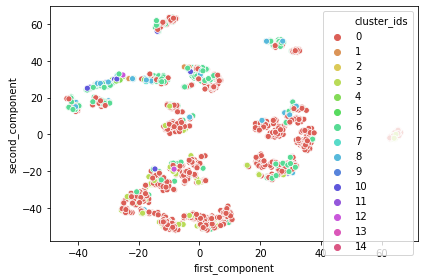

In [232]:
sns.scatterplot(x="first_component", y="second_component", hue="cluster_ids", palette=sns.color_palette("hls", 15), data=cluster_base_df, legend="full")
plt.tight_layout()

In [233]:
original_df = train_set.copy(deep=True)

In [235]:
original_df["cluster_ids"] = cluster_base_df["cluster_ids"]

In [236]:
neighborhood_values = list(original_df.Neighborhood.unique())

## Citation:
Batching: https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks

In [249]:
# figures, axes = plt.subplots(1, 3)

cluster_neighbor = {}
sample_plots = 0
for i in range(20):
    filter_df = original_df[original_df["cluster_ids"] == i].groupby(["Neighborhood"])["SalePrice"].agg(["count"]).reset_index()
    shapes = filter_df.shape
#     print(str(shapes))
#     if shapes[0] > 2 and shapes[0] < 10 and sample_plots < 3:
#         sns.countplot(x='Neighborhood', data=filter_df, ax=axes[sample_plots])
#         axes[sample_plots].set_title("Cluster number: " + str(i))
#         sample_plots += 1

    if shapes[0] > 0:
        cluster_neighbor[i] = filter_df.iloc[filter_df["count"].idxmax()]["Neighborhood"]
    
# plt.tight_layout()
    

In [250]:
cluster_neighbor

{0: 'NAmes',
 1: 'NridgHt',
 2: 'ClearCr',
 3: 'Edwards',
 4: 'NridgHt',
 5: 'NoRidge',
 6: 'CollgCr',
 7: 'NoRidge',
 8: 'NridgHt',
 9: 'ClearCr',
 10: 'NridgHt',
 11: 'Timber',
 12: 'Edwards',
 13: 'Timber',
 14: 'ClearCr'}

## Task 6

In [254]:
train_set.corr().nlargest(5, 'SalePrice')

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,desirability
SalePrice,-0.021917,-0.084284,0.351799,0.263843,0.790982,-0.077856,0.522897,0.507101,0.477493,0.386420,...,0.315856,-0.128578,0.044584,0.111447,0.092404,-0.021190,0.046432,-0.028923,1.000000,0.783958
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982,0.771165
desirability,-0.013492,-0.147957,0.327216,0.169409,0.771165,-0.198524,0.805941,0.697021,0.419579,0.310212,...,0.304594,-0.258441,0.045373,0.019402,0.062810,-0.035519,0.037275,-0.018644,0.783958,1.000000
GrLivArea,0.008273,0.074853,0.402797,0.263116,0.593007,-0.079686,0.199010,0.287389,0.390857,0.208171,...,0.330224,0.009113,0.020643,0.101510,0.170205,-0.002416,0.050240,-0.036526,0.708624,0.520934
GarageCars,0.016570,-0.040110,0.285691,0.154871,0.600671,-0.185758,0.537850,0.420622,0.364204,0.224054,...,0.213569,-0.151434,0.035765,0.050494,0.020934,-0.043080,0.040522,-0.039117,0.640409,0.721384


## Most important features to attempt
OverallQual </br>
YearBuilt </br>
YearRemodAdd </br>
MasVnrArea </br>
desirability </br>
GarageCars </br>
GrLivArea </br>
GarageArea </br>
TotalBsmtSF </br>
1stFlrSF </br>


C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [264]:
input_dataset_x = pre_process_df.drop(['SalePrice'], axis=1)
input_dataset_y = pre_process_df['SalePrice']

In [415]:
X_train, X_test, y_train, y_test = train_test_split(input_dataset_x, input_dataset_y, random_state=31)

In [417]:
train_base = pd.read_csv("data/train.csv")
test_base = pd.read_csv("data/test.csv")
test_base['SalePrice'] = -1.0
global_set = pd.concat([train_base,test_base])


global_cols = set(global_set.columns.tolist())
train_cols = set(train_base.columns.tolist())
test_cols = set(test_base.columns.tolist())

### Handling skewed features
Citation: https://www.geeksforgeeks.org/python-pandas-dataframe-skew/

In [478]:
numerical_columns_except_sales = set(global_set._get_numeric_data().columns.tolist())
# numerical_columns_except_sales = numerical_columns_except_sales - set(['SalePrice'])

numerical_columns_except_sales = list(numerical_columns_except_sales)

skewed_params = global_set[numerical_columns_except_sales].apply(lambda x: skew(x.dropna())) 
skewed_params = skewed_params[skewed_params > 0.80]
skewed_params = skewed_params.index
skewed_params = list(skewed_params)

In [479]:
skewed_params

['GrLivArea',
 'BsmtUnfSF',
 'EnclosedPorch',
 'OpenPorchSF',
 'KitchenAbvGr',
 'PoolArea',
 '2ndFlrSF',
 'LotArea',
 'BsmtHalfBath',
 'LowQualFinSF',
 'ScreenPorch',
 'MSSubClass',
 'TotalBsmtSF',
 '1stFlrSF',
 'BsmtFinSF2',
 'MasVnrArea',
 'SalePrice',
 'MiscVal',
 '3SsnPorch',
 'BsmtFinSF1',
 'LotFrontage',
 'WoodDeckSF']

### Ignoring common null columns containing in both train and test data-set
In the end, checking whether both the sets are same

In [480]:
global_null_columns = set(global_set.columns[global_set.isnull().sum() > 0])
train_non_null_columns = train_cols - global_null_columns
test_non_null_columns = test_cols - global_null_columns

global_non_null_cols = global_set.columns[pre_process_df.isnull().sum() == 0]
global_non_null_cols = global_non_null_cols.tolist()

In [481]:
print(str(train_non_null_columns == test_non_null_columns))

True


### Pre-processing train-test data

In [482]:
train_pre_process = train_base.copy(deep=True)
test_pre_process = test_set.copy(deep=True)

In [483]:
train_pre_process[skewed_params] = np.log1p(train_pre_process[skewed_params])
test_pre_process[skewed_params] = np.log1p(test_pre_process[skewed_params])

C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log1p
  
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


### Encoding categorical columns in training set

In [484]:
train_pre_process = train_pre_process[train_non_null_columns]
numeric_cols = train_pre_process._get_numeric_data().columns
categorical_cols = list(set(train_pre_process.columns) - set(numeric_cols))

total_cat_cols = len(categorical_cols)
done = 0
for c in categorical_cols:
    print("Done: {0}, total: {2}, processing: {1}".format(str(done), str(total_cat_cols), str(c)))
    one_hot_encoding = pd.get_dummies(train_pre_process[c], prefix=c)
    train_pre_process = train_pre_process.drop(c, axis=1)
    train_pre_process = train_pre_process.join(one_hot_encoding)
    done += 1

Done: 0, total: LandContour, processing: 20
Done: 1, total: ExterQual, processing: 20
Done: 2, total: LandSlope, processing: 20
Done: 3, total: LotShape, processing: 20
Done: 4, total: Heating, processing: 20
Done: 5, total: Condition1, processing: 20
Done: 6, total: BldgType, processing: 20
Done: 7, total: Condition2, processing: 20
Done: 8, total: Street, processing: 20
Done: 9, total: HouseStyle, processing: 20
Done: 10, total: CentralAir, processing: 20
Done: 11, total: RoofStyle, processing: 20
Done: 12, total: HeatingQC, processing: 20
Done: 13, total: ExterCond, processing: 20
Done: 14, total: LotConfig, processing: 20
Done: 15, total: RoofMatl, processing: 20
Done: 16, total: Foundation, processing: 20
Done: 17, total: Neighborhood, processing: 20
Done: 18, total: SaleCondition, processing: 20
Done: 19, total: PavedDrive, processing: 20


### Encoding categorical columns in test set

In [485]:
# train_cols = set(train_pre_process.columns.tolist())
test_pre_process = test_pre_process[test_non_null_columns]
numeric_cols = test_pre_process._get_numeric_data().columns
categorical_cols = list(set(test_pre_process.columns) - set(numeric_cols))

total_cat_cols = len(categorical_cols)
done = 0
for c in categorical_cols:
    print("Done: {0}, total: {2}, processing: {1}".format(str(done), str(total_cat_cols), str(c)))
    one_hot_encoding = pd.get_dummies(test_pre_process[c], prefix=c)
    test_pre_process = test_pre_process.drop(c, axis=1)
    test_pre_process = test_pre_process.join(one_hot_encoding)
    done += 1


Done: 0, total: LandContour, processing: 20
Done: 1, total: ExterQual, processing: 20
Done: 2, total: LandSlope, processing: 20
Done: 3, total: LotShape, processing: 20
Done: 4, total: Heating, processing: 20
Done: 5, total: Condition1, processing: 20
Done: 6, total: BldgType, processing: 20
Done: 7, total: Condition2, processing: 20
Done: 8, total: Street, processing: 20
Done: 9, total: HouseStyle, processing: 20
Done: 10, total: CentralAir, processing: 20
Done: 11, total: RoofStyle, processing: 20
Done: 12, total: HeatingQC, processing: 20
Done: 13, total: ExterCond, processing: 20
Done: 14, total: LotConfig, processing: 20
Done: 15, total: RoofMatl, processing: 20
Done: 16, total: Foundation, processing: 20
Done: 17, total: Neighborhood, processing: 20
Done: 18, total: SaleCondition, processing: 20
Done: 19, total: PavedDrive, processing: 20


In [486]:
train_categorical_cols = set(train_pre_process.columns.tolist())
test_categorical_cols = set(test_pre_process.columns.tolist())
all_categorical_cols = train_categorical_cols.union(test_categorical_cols)
common_cols = all_categorical_cols - (train_categorical_cols - test_categorical_cols) - (test_categorical_cols - train_categorical_cols)

In [487]:
common_cols = list(common_cols)
train_post_process = train_pre_process[common_cols]
test_post_process = test_pre_process[common_cols]

In [488]:
X_train, X_test, y_train, y_test = train_test_split(train_post_process.drop(['SalePrice'], axis=1), train_post_process['SalePrice'], random_state=31)

In [489]:
regressor = LinearRegression()
regressor = regressor.fit(X_train, y_train)

In [490]:
y_pred = regressor.predict(X_test)

In [491]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.1010509265248996
Mean Squared Error: 0.023095278004070137
Root Mean Squared Error: 0.15197130651563845


In [492]:
test_output = regressor.predict(test_post_process.drop(['SalePrice'], axis=1))

In [499]:
test_post_process['SalePrice'] = np.expm1(test_output)

In [500]:
test_post_process[["Id", "SalePrice"]].to_csv("submissiom.csv", sep=',', index=False)

## Task 7